## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
from joblib import Parallel, delayed
import os

import pandas as pd
from tqdm import tqdm

from darts import TimeSeries
from darts.models import XGBModel

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.light_gbm.feature_engineering.ts_fresh_features import (
    make_roll,
    make_roll_features,
)
from storesales.light_gbm.data_series.target_series import get_series_and_id_dicts
from storesales.light_gbm.data_series.covariates import get_covariates_dicts
from storesales.light_gbm.preprocessing import preprocess
from storesales.light_gbm.utils import save_submission
from storesales.light_gbm.loss import clipped_rmsle
from storesales.constants import (
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
    TRAIN_TEST_SPLIT_DATE,
    MODELS_PATH,
    EXTERNAL_OIL_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
oil_df = pd.read_csv(EXTERNAL_OIL_PATH, parse_dates=["date"])
oil_df.set_index("date", inplace=True)
oil_df = oil_df.asfreq("D")
oil_df["dcoilwtico"] = oil_df["dcoilwtico"].ffill()
oil_df = oil_df.dropna()

In [5]:
preprocessed_df = preprocess(train_df)

In [6]:
preprocessed_df.fillna(0, inplace=True)

## Prepare Data Before Making Series

In [7]:
train_end = train_df["date"].max()
test_start = test_df["date"].min()

In [8]:
END_TEST_RANGE = train_df["date"].max() - pd.Timedelta(days=16)
SERIES_TEST_RANGE = pd.date_range(TRAIN_TEST_SPLIT_DATE, END_TEST_RANGE, freq="D")

In [9]:
families = ["LIQUOR,WINE,BEER", "SCHOOL AND OFFICE SUPPLIES", "LINGERIE"]
train_columns = ["date", "sales", "onpromotion", "store_nbr", "family"]

train_test_df = pd.concat([preprocessed_df, test_df], axis=0, ignore_index=True)
train_data = train_test_df[train_test_df["family"].isin(families)][train_columns].copy()

In [10]:
train_data = train_data.merge(oil_df, left_on="date", right_index=True, how="left")

### Ensure that I have enough data to get lags

In [11]:
threshold_date = pd.Timestamp("2017-04-01")

In [12]:
min_dates = train_data.groupby(["family", "store_nbr"])["date"].min().reset_index()
lgb_groups = min_dates[min_dates["date"] <= threshold_date]

In [13]:
lgb_train_data = pd.merge(
    train_data,
    lgb_groups[["family", "store_nbr"]],
    on=["family", "store_nbr"],
    how="inner",
)

## Baseline Model
Some store-family pairs do not have enough data to get lags. I will use baseline model for these pairs.

### Prepare Data

In [15]:
baseline_groups = min_dates[min_dates["date"] > threshold_date]

In [16]:
baseline_train_data = train_df.copy()
baseline_test_data = test_df.copy()

baseline_train_data.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
baseline_test_data.rename(columns={"date": "ds"}, inplace=True)

### Load Model && Fit && Predict

In [17]:
model_file = os.path.join(MODELS_PATH, "daily_predictor.pkl")
baseline_predictor = SalesPredictor.load(model_file)

In [18]:
baseline_predictor.fit(baseline_train_data)

100%|██████████| 1782/1782 [00:00<00:00, 1999.11it/s]


In [19]:
baseline_prediction = baseline_predictor.predict(baseline_test_data)

100%|██████████| 1782/1782 [00:00<00:00, 4180.75it/s]


### Load Baseline Evaluation Loss

In [20]:
predictor_eval_loss_df = pd.read_csv(
    baseline_predictor.eval_loss_csv, index_col=["family", "store_nbr"]
)

baseline_loss_ids = pd.MultiIndex.from_frame(baseline_groups[["family", "store_nbr"]])
baseline_loss_df = predictor_eval_loss_df.loc[baseline_loss_ids]

## Rolling Features
### Make Rolls

In [21]:
rolls_threshold_date = pd.Timestamp("2015-03-01")

In [22]:
lgb_rolls_data = lgb_train_data[lgb_train_data["date"] >= rolls_threshold_date].copy()

In [23]:
all_train_rolls = make_roll(lgb_rolls_data)

Rolling: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


In [24]:
all_train_rolls.fillna(0, inplace=True)  # fill test period sales

### Make Features

In [25]:
train_featured = make_roll_features(all_train_rolls)

Feature Extraction: 100%|██████████| 30/30 [01:59<00:00,  3.99s/it]


In [39]:
train_featured.head()

,date,sales__sum_values,sales__median,sales__mean,sales__length,sales__standard_deviation,sales__variance,sales__root_mean_square,sales__maximum,sales__absolute_maximum,...,dcoilwtico__mean,dcoilwtico__length,dcoilwtico__standard_deviation,dcoilwtico__variance,dcoilwtico__root_mean_square,dcoilwtico__maximum,dcoilwtico__absolute_maximum,dcoilwtico__minimum,store_nbr,family
0,2015-03-31,145.0,4.0,4.677419,31.0,5.561313,30.928200,7.266805,31.0,31.0,...,47.761290,31.0,2.306747,5.321082,47.816963,51.53,51.53,43.39,1,LINGERIE
1,2015-04-01,152.0,4.0,4.903226,31.0,5.549512,30.797086,7.405316,31.0,31.0,...,47.770323,31.0,2.315401,5.361081,47.826403,51.53,51.53,43.39,1,LINGERIE
2,2015-04-02,125.0,4.0,4.032258,31.0,2.845300,8.095734,4.935062,13.0,13.0,...,47.755484,31.0,2.305143,5.313683,47.811086,51.53,51.53,43.39,1,LINGERIE
3,2015-04-03,121.0,4.0,3.903226,31.0,2.933179,8.603538,4.882490,13.0,13.0,...,47.713548,31.0,2.267626,5.142126,47.767403,51.53,51.53,43.39,1,LINGERIE
4,2015-04-04,121.0,4.0,3.903226,31.0,2.933179,8.603538,4.882490,13.0,13.0,...,47.636129,31.0,2.175087,4.731004,47.685761,51.41,51.41,43.39,1,LINGERIE


## Prepare Series

In [40]:
sales_cols = [col for col in train_featured.columns if "sales" in col]
onpromotion_cols = [col for col in train_featured.columns if "onpromotion" in col]
oil_cols = [col for col in train_featured.columns if "dcoilwtico" in col]

future_cols = onpromotion_cols + oil_cols
past_cols = sales_cols

In [41]:
def train_test_split(series: dict[str, list[TimeSeries]], split_date: pd.Timestamp):
    train_series = {}

    for family, series_list in series.items():
        train_series[family] = [s.drop_after(split_date) for s in series_list]

    return train_series

In [45]:
static_columns = []

data_series_dict, data_series_id_dict = get_series_and_id_dicts(
    lgb_train_data, static_columns
)

In [46]:
future_covariates, past_covariates = get_covariates_dicts(
    train_featured, future_cols, past_cols
)

In [47]:
train_series_dict = train_test_split(
    data_series_dict, pd.Timestamp(TRAIN_TEST_SPLIT_DATE)
)

In [95]:
def fit_light_gb_models():
    light_gb_models = {}

    for family, series in train_series_dict.items():
        inputs = {
            "series": series,
            "future_covariates": future_covariates[family],
            "past_covariates": past_covariates[family],
        }
        light_gb_models[family] = XGBModel(
            lags=24,
            lags_future_covariates=[-30, -25, -20, -15, -10, -5, 0],
            lags_past_covariates=[-30, -25, -20, -16],
        )

        light_gb_models[family].fit(**inputs)

    return light_gb_models

In [96]:
models = fit_light_gb_models()

In [97]:
def evaluate():
    def evaluate_family(family):
        series = data_series_dict[family]
        lgb_family_stores = [
            element["store_nbr"] for element in data_series_id_dict[family]
        ]
        multi_index = pd.MultiIndex.from_product(
            [[family], lgb_family_stores], names=["family", "store_nbr"]
        )

        family_losses = []
        for test_date in SERIES_TEST_RANGE:
            inputs = {
                "series": [s.drop_after(test_date) for s in series],
                "future_covariates": future_covariates[family],
                "past_covariates": past_covariates[family],
            }

            preds = models[family].predict(n=16, show_warnings=False, **inputs)
            true_values = [s.slice_intersect(p) for p, s in zip(preds, series)]

            loss = [
                clipped_rmsle(t.values(), p.values())
                for t, p in zip(true_values, preds)
            ]
            series_loss = pd.Series(
                loss, index=multi_index, name=test_date.strftime("%Y.%m.%d")
            )

            family_losses.append(series_loss)

        family_losses_df = pd.concat(family_losses, axis=1)
        return family_losses_df

    losses = Parallel(n_jobs=-1)(
        delayed(evaluate_family)(family) for family in tqdm(data_series_dict.keys())
    )

    return pd.concat(losses)

In [98]:
eval_family_losses = evaluate()

100%|██████████| 3/3 [00:00<00:00, 3687.84it/s]


In [99]:
total_lgb_loss = pd.concat([eval_family_losses, baseline_loss_df]).sort_index(
    level=["family", "store_nbr"]
)

In [100]:
grouped_loss = total_lgb_loss.groupby("family").mean()
lgb_series_loss = grouped_loss.mean(axis=1).rename("lgb_series_loss")

predictor_grouped_loss = predictor_eval_loss_df.groupby("family").mean()
baseline_series_loss = predictor_grouped_loss.mean(axis=1).rename("baseline_loss")

loss_df = pd.concat([lgb_series_loss, baseline_series_loss], axis=1)

In [101]:
loss_df

,lgb_series_loss,baseline_loss
family,,
LINGERIE,0.688776,0.683757
"LIQUOR,WINE,BEER",0.657072,0.708146
SCHOOL AND OFFICE SUPPLIES,0.655088,0.644878
AUTOMOTIVE,NaN,0.549853
BABY CARE,NaN,0.194055
BEAUTY,NaN,0.574898
BEVERAGES,NaN,0.275564
BOOKS,NaN,0.078480
BREAD/BAKERY,NaN,0.236766


In [102]:
total_prediction_eval_loss = loss_df["lgb_series_loss"].fillna(loss_df["baseline_loss"])
print("Loss with LightGBM:", total_prediction_eval_loss.mean())

Loss with LightGBM: 0.4166476671199474


In [103]:
print("Loss without LightGBM:", loss_df["baseline_loss"].mean())

Loss without LightGBM: 0.4177338467167706


## Submission

In [104]:
test_df_copy = baseline_prediction.copy()

In [105]:
test_df_copy.set_index(["ds", "family", "store_nbr"], inplace=True)

In [106]:
def make_predictions():
    for family, series in tqdm(data_series_dict.items()):
        inputs = {
            "series": [s.drop_after(test_start) for s in series],
            "future_covariates": future_covariates[family],
            "past_covariates": past_covariates[family],
        }
        pred = models[family].predict(n=16, **inputs)

        for i, values in enumerate(pred):
            store_nbr = int(data_series_id_dict[family][i]["store_nbr"])

            pred_df = values.pd_dataframe()
            pred_df[["family", "store_nbr"]] = [family, store_nbr]
            pred_df.set_index(["family", "store_nbr"], append=True, inplace=True)
            pred_df.index.names = ["ds", "family", "store_nbr"]

            test_df_copy.loc[pred_df.index, "yhat"] = pred_df["sales"]

    return test_df_copy

In [107]:
prediction = make_predictions()

prediction.isna().sum()

100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


id             0
onpromotion    0
yhat           0
dtype: int64

In [132]:
store_nbr_i = 33
family = "LIQUOR,WINE,BEER"
store_nbr = data_series_id_dict[family][store_nbr_i]["store_nbr"]
print(store_nbr)

vals = data_series_dict[family][store_nbr_i].drop_before(pd.Timestamp("2017-02-01")).pd_dataframe()
vals.index.name = "ds"

34


In [133]:
plot_data = prediction.reset_index()

predict_vals = plot_data[((plot_data["family"] == family) & (plot_data["store_nbr"] == store_nbr))][["ds", "yhat"]]
predict_vals.set_index("ds", inplace=True)
predict_vals.rename(columns={"yhat": "sales"}, inplace=True)

<Axes: xlabel='ds'>

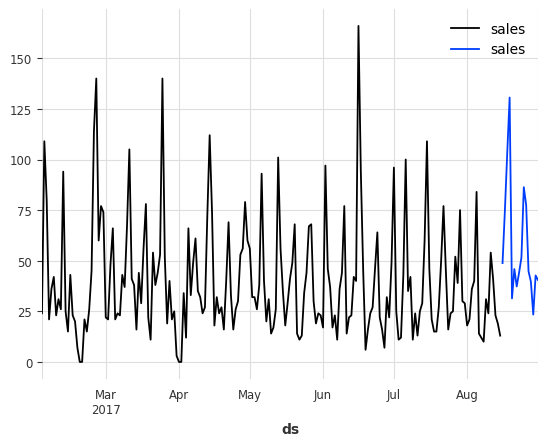

In [134]:
pd.concat([vals, predict_vals], axis=1).plot()

In [135]:
prediction.head()

,,,id,onpromotion,yhat
ds,family,store_nbr,,,
2017-08-16,AUTOMOTIVE,1,3000888,0,4.8125
2017-08-17,AUTOMOTIVE,1,3002670,0,4.8125
2017-08-18,AUTOMOTIVE,1,3004452,0,4.8125
2017-08-19,AUTOMOTIVE,1,3006234,0,4.8125
2017-08-20,AUTOMOTIVE,1,3008016,0,4.8125


## Save Submission

In [136]:
prediction.set_index("id", inplace=True)

In [137]:
save_submission(prediction, "fix.csv")

sales    0
dtype: int64


In [188]:
prediction.head()

,onpromotion,yhat
id,,
3000888,0,4.8125
3002670,0,4.8125
3004452,0,4.8125
3006234,0,4.8125
3008016,0,4.8125
